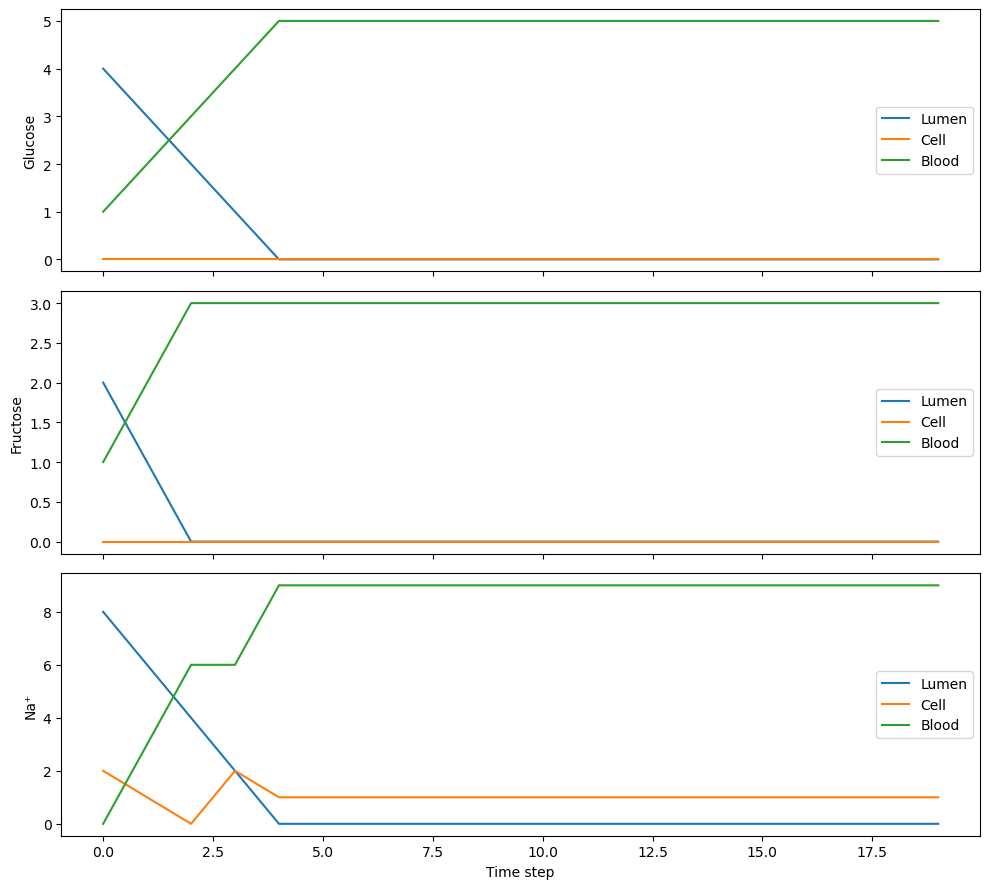

In [1]:
import matplotlib.pyplot as plt
from dataclasses import dataclass

@dataclass
class TransportParams:
    sglt1_rate: float = 1.0      # Glucose units per step (requires 2 Na+)
    glut5_rate: float = 1.0      # Fructose units per step
    glut2_rate: float = 1.0      # Glucose and fructose units per step
    nak_cycles: int = 1          # Na/K pump cycles per step

@dataclass
class Compartment:
    glucose: float
    fructose: float
    na: float
    k: float

def simulate_transport(params: TransportParams, steps=20):
    # Initial states
    lumen = Compartment(glucose=5.0, fructose=3.0, na=10.0, k=0.0)
    cell = Compartment(glucose=0.0, fructose=0.0, na=0.0, k=2.0)
    blood = Compartment(glucose=0.0, fructose=0.0, na=0.0, k=10.0)

    # Tracking data
    lumen_data, cell_data, blood_data = [], [], []

    for t in range(steps):
        # --- SGLT1 ---
        if lumen.glucose >= params.sglt1_rate and lumen.na >= 2 * params.sglt1_rate:
            lumen.glucose -= params.sglt1_rate
            lumen.na -= 2 * params.sglt1_rate
            cell.glucose += params.sglt1_rate
            cell.na += 2 * params.sglt1_rate

        # --- GLUT5 ---
        if lumen.fructose >= params.glut5_rate:
            lumen.fructose -= params.glut5_rate
            cell.fructose += params.glut5_rate

        # --- GLUT2 ---
        if cell.glucose >= params.glut2_rate:
            cell.glucose -= params.glut2_rate
            blood.glucose += params.glut2_rate
        if cell.fructose >= params.glut2_rate:
            cell.fructose -= params.glut2_rate
            blood.fructose += params.glut2_rate

        # --- Na⁺/K⁺ Pump ---
        for _ in range(params.nak_cycles):
            if cell.na >= 3 and blood.k >= 2:
                cell.na -= 3
                blood.na += 3
                blood.k -= 2
                cell.k += 2

        # Store concentrations
        lumen_data.append((lumen.glucose, lumen.fructose, lumen.na))
        cell_data.append((cell.glucose, cell.fructose, cell.na))
        blood_data.append((blood.glucose, blood.fructose, blood.na))

    return lumen_data, cell_data, blood_data

# Run simulation
params = TransportParams()
lumen_data, cell_data, blood_data = simulate_transport(params, steps=20)

# Plotting
time = list(range(20))
fig, axs = plt.subplots(3, 1, figsize=(10, 9), sharex=True)

# Glucose
axs[0].plot(time, [x[0] for x in lumen_data], label='Lumen')
axs[0].plot(time, [x[0] for x in cell_data], label='Cell')
axs[0].plot(time, [x[0] for x in blood_data], label='Blood')
axs[0].set_ylabel("Glucose")
axs[0].legend()

# Fructose
axs[1].plot(time, [x[1] for x in lumen_data], label='Lumen')
axs[1].plot(time, [x[1] for x in cell_data], label='Cell')
axs[1].plot(time, [x[1] for x in blood_data], label='Blood')
axs[1].set_ylabel("Fructose")
axs[1].legend()

# Sodium
axs[2].plot(time, [x[2] for x in lumen_data], label='Lumen')
axs[2].plot(time, [x[2] for x in cell_data], label='Cell')
axs[2].plot(time, [x[2] for x in blood_data], label='Blood')
axs[2].set_ylabel("Na⁺")
axs[2].set_xlabel("Time step")
axs[2].legend()

plt.tight_layout()
plt.show()


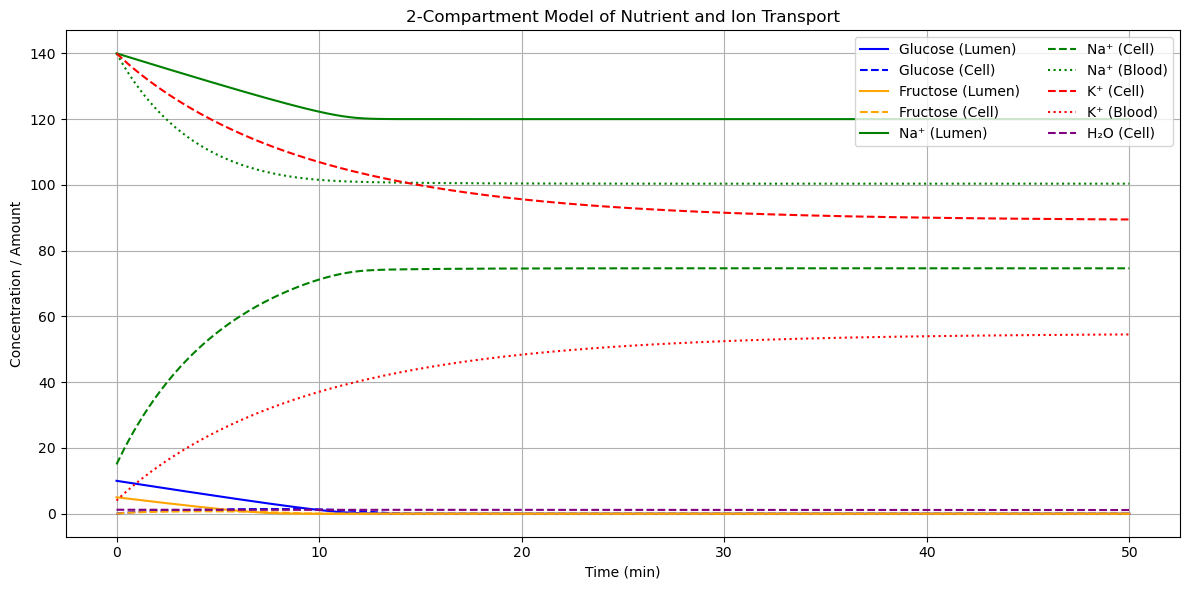

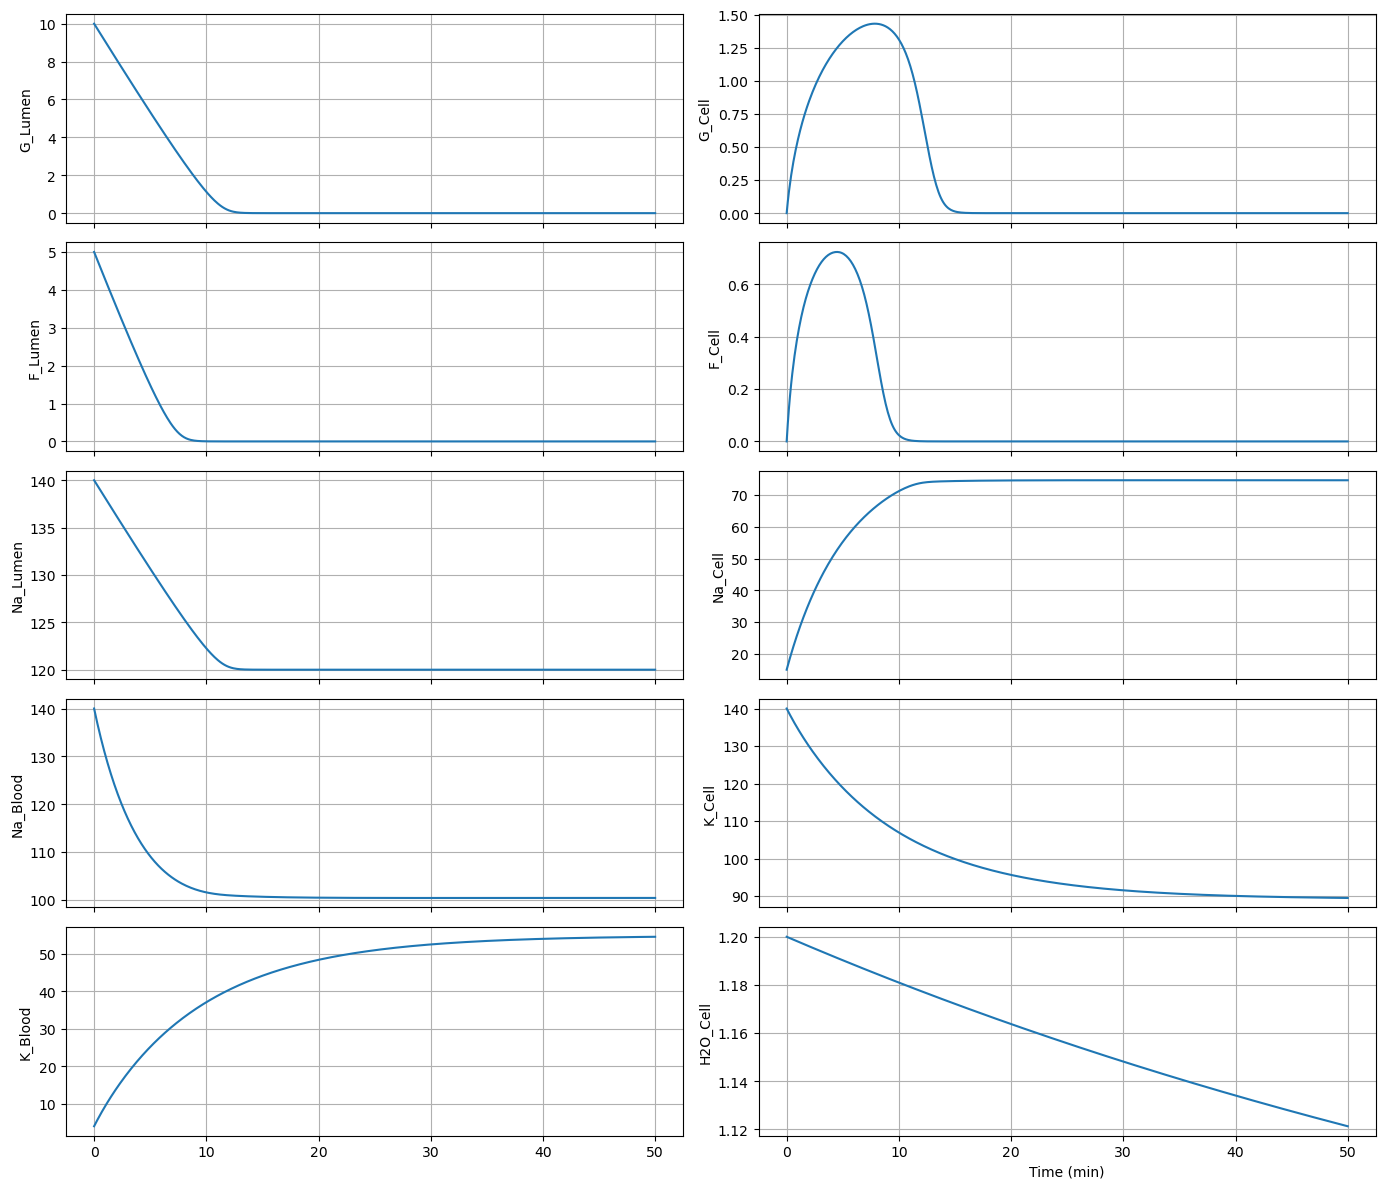

In [3]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from dataclasses import dataclass

@dataclass
class TransportParams:
    # Michaelis-Menten constants (units: mM or mM/s)
    Vmax_sglt1: float = 1.0
    Km_sglt1: float = 0.5
    Vmax_glut5: float = 0.8
    Km_glut5: float = 0.4
    Vmax_glut2: float = 1.2
    Km_glut2: float = 0.6
    Vmax_nak: float = 1.0
    Km_nak_Na: float = 10.0
    Km_nak_K: float = 1.5

    # Diffusion rates (Fick’s law, simplified)
    P_Na: float = 0.1
    P_K: float = 0.05
    P_H2O: float = 0.01

def transporter_model(t, y, p):
    # y = [G_lumen, G_cell, F_lumen, F_cell, Na_lumen, Na_cell, Na_blood, K_cell, K_blood, H2O_cell]
    G_L, G_C, F_L, F_C, Na_L, Na_C, Na_B, K_C, K_B, H2O_C = y

    # --- SGLT1 ---
    sglt1 = p.Vmax_sglt1 * (G_L / (p.Km_sglt1 + G_L)) * (Na_L / (p.Km_sglt1 + Na_L))

    # --- GLUT5 ---
    glut5 = p.Vmax_glut5 * (F_L / (p.Km_glut5 + F_L))

    # --- GLUT2 (glucose and fructose efflux from cell to blood)
    glut2_G = p.Vmax_glut2 * (G_C / (p.Km_glut2 + G_C))
    glut2_F = p.Vmax_glut2 * (F_C / (p.Km_glut2 + F_C))

    # --- Na⁺/K⁺ Pump ---
    nak = p.Vmax_nak * (Na_C / (p.Km_nak_Na + Na_C)) * (K_B / (p.Km_nak_K + K_B))

    # --- Passive Diffusion ---
    diff_Na = p.P_Na * (Na_C - Na_B)
    diff_K = p.P_K * (K_B - K_C)
    diff_H2O = p.P_H2O * (H2O_C - 1.0)  # assume blood is isotonic (1.0)

    # --- Differential Equations ---
    dG_L = -sglt1
    dG_C = sglt1 - glut2_G

    dF_L = -glut5
    dF_C = glut5 - glut2_F

    dNa_L = -2 * sglt1
    dNa_C = 2 * sglt1 - 3 * nak - diff_Na
    dNa_B = 3 * nak + diff_Na

    dK_C = 2 * nak + diff_K
    dK_B = -2 * nak - diff_K

    dH2O_C = -diff_H2O  # Water outflux

    return [dG_L, dG_C, dF_L, dF_C, dNa_L, dNa_C, dNa_B, dK_C, dK_B, dH2O_C]

# Initial concentrations [mM]
y0 = [
    10.0,  # G_Lumen
    0.0,   # G_Cell
    5.0,   # F_Lumen
    0.0,   # F_Cell
    140.0, # Na_Lumen
    15.0,  # Na_Cell
    140.0, # Na_Blood
    140.0, # K_Cell
    4.0,   # K_Blood
    1.2    # H2O_Cell (arbitrary units)
]

# Time span
t_span = (0, 50)  # 50 minutes
t_eval = np.linspace(*t_span, 500)

# Run simulation
params = TransportParams()
sol = solve_ivp(transporter_model, t_span, y0, args=(params,), t_eval=t_eval)

# Combined plot
plt.figure(figsize=(12, 6))

# Define color and line style maps
colors = {
    "Glucose": "blue",
    "Fructose": "orange",
    "Na⁺": "green",
    "K⁺": "red",
    "H₂O": "purple"
}

styles = {
    "Lumen": "-",
    "Cell": "--",
    "Blood": ":"
}

# Labels and their index in sol.y
species_labels = {
    "G_Lumen": (0, "Glucose", "Lumen"),
    "G_Cell": (1, "Glucose", "Cell"),
    "F_Lumen": (2, "Fructose", "Lumen"),
    "F_Cell": (3, "Fructose", "Cell"),
    "Na_Lumen": (4, "Na⁺", "Lumen"),
    "Na_Cell": (5, "Na⁺", "Cell"),
    "Na_Blood": (6, "Na⁺", "Blood"),
    "K_Cell": (7, "K⁺", "Cell"),
    "K_Blood": (8, "K⁺", "Blood"),
    "H2O_Cell": (9, "H₂O", "Cell"),
}

for label, (idx, species, loc) in species_labels.items():
    plt.plot(
        sol.t, sol.y[idx],
        label=f"{species} ({loc})",
        color=colors[species],
        linestyle=styles.get(loc, "-")
    )

plt.xlabel("Time (min)")
plt.ylabel("Concentration / Amount")
plt.title("2-Compartment Model of Nutrient and Ion Transport")
plt.legend(loc="upper right", ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


# Plotting
labels = [
    "G_Lumen", "G_Cell", "F_Lumen", "F_Cell",
    "Na_Lumen", "Na_Cell", "Na_Blood",
    "K_Cell", "K_Blood", "H2O_Cell"
]

fig, axs = plt.subplots(5, 2, figsize=(14, 12), sharex=True)
axs = axs.flatten()

for i, ax in enumerate(axs):
    ax.plot(sol.t, sol.y[i], label=labels[i])
    ax.set_ylabel(labels[i])
    ax.grid(True)

axs[-1].set_xlabel("Time (min)")
plt.tight_layout()
plt.show()
